[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NLTGit/OpenNightLights-colab-mirror/blob/master/onl/tutorials/mod5_4_comparing_cities.ipynb)


# Comparing cities (5 min)

Let's pull a bit of what we've learned together and compare some cities we've seen throughout the tutorial.

First we'll compare time series, then we'll calculate the rate of change and compare this as well.

**Our tasks in this exercise:**
1. Get VIIRS-DNB data for 2014-2020 and geometries for Berlin, Seoul, and Sao Paulo
2. Compare time series
3. Calculate rate of change and compare with histograms

## Get VIIRS data and city geometries

We'll get an ImageCollection of VIIRS-DNB (stray-light corrected) for all available months. And the geometries for our select cities.

In [1]:
# !pip install geemap pandas
# !pip install --upgrade seaborn

In [2]:
import geemap, ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").select('avg_rad')
      
select_cities = ['Berlin','Seoul','Sao Paulo']
city_geoms = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.inList('ADM1_NAME', select_cities))

We'll define a reducer for our collection of city geometries.

There's some data wrangling below to get our data structured properly. See if you can understand what's happening...but don't worry if you can't and keep moving on!

In [3]:
# function to reduce our collection of geometries
def get_city_avg_rad(img):
    return img.reduceRegions(reducer=ee.Reducer.mean(), collection=city_geoms, scale=500)

# function to get individual img dates
def get_date(img):
    return img.set('date', img.date().format())

# map these functions to our image collection
reduced_cities = viirs.map(get_city_avg_rad).flatten()
dates = viirs.map(get_date)

# get lists
key_cols = ['ADM1_NAME','mean']
cities_list = reduced_cities.reduceColumns(ee.Reducer.toList(len(key_cols)), key_cols).values()
dates_list = dates.reduceColumns(ee.Reducer.toList(1), ['date']).values()

# some numpy maneuvers to structure our data
df = pd.DataFrame(np.asarray(cities_list.getInfo()).squeeze(), columns=key_cols)
dates = np.asarray(dates_list.getInfo()).squeeze()

for city in select_cities:
    df.loc[df['ADM1_NAME']==city,'dates'] = dates
    
# as we've done before, convert date and set index
df['dates'] = pd.to_datetime(df['dates'])
df.set_index('dates', inplace=True)

# we'll also convert our mean datatype to float
df['mean'] = df['mean'].astype(float)

In [4]:
df

,ADM1_NAME,mean
dates,,
2014-01-01,Sao Paulo,1.792589
2014-01-01,Berlin,18.209309
2014-01-01,Seoul,48.085756
2014-02-01,Sao Paulo,1.764743
2014-02-01,Berlin,15.194246
...,...,...
2020-04-01,Berlin,15.768813
2020-04-01,Seoul,50.324428
2020-05-01,Sao Paulo,1.912650


Does anything seem odd about these outliers? What do we know about our underlying geometries (i.e. are we positive they are comparable across cities?)


## Compare time series

We can plot our time series. Because we chose a scaled metric (mean radiance, instead of SOL), these data are standardized and we can compare them directly.

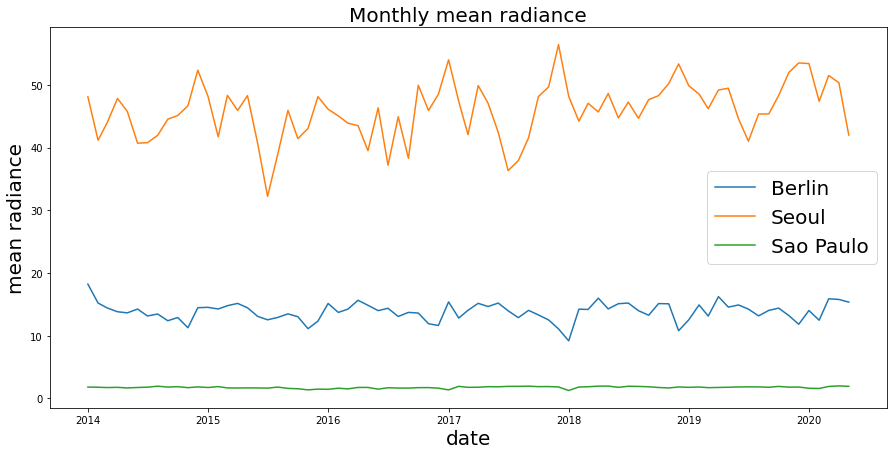

In [5]:
fig, ax = plt.subplots(figsize=(15,7))

# we'll draw a plot for each city in our list
for city in select_cities:
    data = df.loc[df['ADM1_NAME']==city,:]
    sns.lineplot(data=data, x=data.index, y='mean', label=city, ax=ax)

# we'll set the labels and title
ax.set_ylabel('mean radiance',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.legend(fontsize=20)
ax.set_title(f'Monthly mean radiance',fontsize=20);

Comparing these three cities, we first see the order of magnitude, such that Seoul has the brightest avg radiance (per pixel per month), followed by Berlin, with Sao Paulo much lower (recall our note earlier about data consistency...perhaps there's an issue with the size of the area being compared? Probably another reason to scale the data by area...)

We dont see dramatic trends of growth or decline for any of these cities.

But can we quantify this? 

## Calculate rate of change

We'll get the rate of change for these cities to quantify any general trends from the first month to the last of the series.

Becuase we already have our data in a dataframe, we could just calculate the rate of change based on our avg radiance per city...but that's losing a lot of information. 

The advantage of calculating rate of change directly on the raster files, as we did in {doc}`mod4_4_rate_of_change` is that we get the per-pixel rate of change directly -- and then we reduce our data to an average or a sum for our region in order to plot or analyze it. 

This may seem like a subtle change, but for larger areas (including large cities), there might be some pixels that see dramatic change over time that are important to calculate before aggregating everything to a citywide average. Calculating the citywide average first for each time period may cause us to lose sensitivity to such spatial dynamics.

### Get rate of change

With GEE its quite easy to reduce our ImageCollection to a representation of the rate of change. Then we can either examine the plot, or perhaps make histograms like we did in {doc}`mod4_2_histograms`.

First lets get the rate of change.

In [6]:
# get first image by sorting by image "time_end"
first_img = viirs.sort('system:time_end').first()

# get last image by reverse sorting (ascending=False)
last_img = viirs.sort('system:time_end',False).first()

# get total periods (months) in our series
periods = int(viirs.size().getInfo())

print(f'series covers {periods} months')

series covers 77 months


In [7]:
viirs_slope = (last_img.subtract(first_img)).divide(periods)

### Let's compare cities by getting a histogram that represents the distribution of the change in nightime lights per month (rate of change) for each city.

We'll loop through our cities and create a Python dictionary that holds each cities data array.

In [8]:
roc_data = {}
for city in select_cities:
    try:
        geom = city_geoms.filter(ee.Filter.eq('ADM1_NAME',city)).geometry()
        roc_data[city] = np.array(viirs_slope.sampleRectangle(region=geom).get('avg_rad').getInfo())
    except:
        print(f"{city} failed due to pixel limits")

Sao Paulo failed due to pixel limits


### Plot probability density using seaborn Kernel Density plots

We'll also use the logscale as we did before.

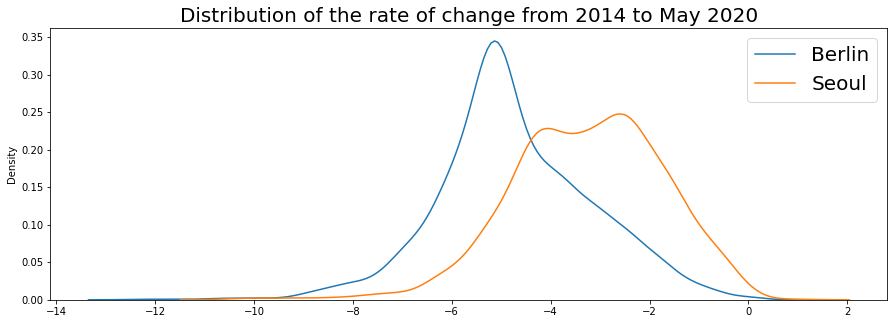

In [9]:
fig, ax = plt.subplots(figsize=(15,5))

# we'll iterate through each key-value pair in our dictionary to plot
for k,v in roc_data.items():
    sns.kdeplot(np.log(v).flatten(), label=k,legend=True, ax=ax)

ax.legend(fontsize=20)
ax.set_title('Distribution of the rate of change from 2014 to May 2020', fontsize=20);

Both cities are showing declines, interestingly, although the decline in nighttime lights for Berlin is sharper and larger than that of Seoul it appears...and Seoul has a wider variance with more pixels appearing to show some positive growth as well.

Let's take a quick look at the rasters...

In [10]:
city='Berlin'
berlinMap = geemap.Map()
geom = city_geoms.filter(ee.Filter.eq('ADM1_NAME',city)).geometry()
berlinMap.centerObject(geom, zoom=10)
berlinMap.addLayer(viirs_slope.clip(geom), {'min':-1.,'max':1},city,opacity=0.7)
berlinMap

Map(center=[52.50307584767821, 13.398289416023259], controls=(WidgetControl(options=['position'], widget=HBox(…

In [11]:
city='Seoul'
seoulMap = geemap.Map()
geom = city_geoms.filter(ee.Filter.eq('ADM1_NAME',city)).geometry()
seoulMap.centerObject(geom, zoom=11)
seoulMap.addLayer(viirs_slope.clip(geom), {'min':-1.,'max':1},city,opacity=0.7)
seoulMap

Map(center=[37.53803118323625, 127.00584943229947], controls=(WidgetControl(options=['position'], widget=HBox(…

In [12]:
city='Sao Paulo'
spMap = geemap.Map()
geom = city_geoms.filter(ee.Filter.eq('ADM1_NAME',city)).geometry()
spMap.centerObject(geom, zoom=6)
spMap.addLayer(viirs_slope.clip(geom), {'min':-1.,'max':1},city,opacity=0.7)
spMap

Map(center=[-22.26179743862149, -48.74090536767993], controls=(WidgetControl(options=['position'], widget=HBox…

First note that we really should be careful comparing...apparently our Admin levels mean "city" for Seoul and Berlin but "province/state" for Sao Paulo! An analysis of these cities must use standard definitions of area. You can research this, but visualizing data quickly is a good empirical gut-check about your research design and assumptions.

Aside from that...
With higher resolution you can see differentation at the neighborhood...and all cities seem to show various patterns of growth and decline, perhaps indicating pockets of construction or development.

We're using May 2020 as our most recent image -- and this is very likely impacted by the effects of COVID-19. Would looking at the rate of change for these cities using different time periods make any difference?

See if you can do some investigation into the trends yourself!

## References:
```{bibliography} ../references.bib
:filter: docname in docnames
```